In [636]:
import pandas as pd
import numpy as np
import sys
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# local import
sys.path.append("../../")
from utils.trackmate import dataEngineering as _tm

In [637]:
data_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/analysis_files/"

b3_path = f"{data_dir}B3/trackmate/"
c7_path = f"{data_dir}C7/trackmate/"


LOW_INTENSITY_THRESHOLD = 0.4

b3 = _tm.load_trackmate_dir(b3_path)
b3 = _tm.merge_tracks_and_all(b3)
b3 = _tm.clean_up_trackSpots(b3, LOW_INTENSITY_THRESHOLD)
b3['file'] = 'B3'
b3['Condition'] = 'MyoD +'
print(b3.shape)


c7 = _tm.load_trackmate_dir(c7_path)
c7 = _tm.merge_tracks_and_all(c7)
c7 = _tm.clean_up_trackSpots(c7, LOW_INTENSITY_THRESHOLD)
c7['file'] = 'C7'
c7['Condition'] = 'Control'
print(c7.shape)

raw = pd.concat([b3, c7], ignore_index=True)
print(raw.shape)


(335160, 68)
(504305, 69)
(839465, 69)


In [638]:
df = raw.copy()

## add track means for green/red intensity

grped = df.groupby(['TRACK_ID', 'file'], as_index=False).agg(
    red_mean = ('MEAN_INTENSITY03', np.mean),
    green_mean = ('MEAN_INTENSITY01', np.mean),
    blue_mean = ('MEAN_INTENSITY02', np.mean),
    red_max = ('MEAN_INTENSITY03', np.max),
    green_max = ('MEAN_INTENSITY01', np.max),
    blue_max = ('MEAN_INTENSITY02', np.max),
)

grped['has_green'] = np.where(grped['green_max'] > 0, 1, 0)
grped['has_blue'] = np.where(grped['blue_max'] > 0, 1, 0)

df = pd.merge(df, 
              grped, 
              how='left',
              on=['TRACK_ID', 'file'])

print(df.shape)
print(df['TRACK_ID'].nunique())

mask = (df['has_blue'] == 1) 
df = df[mask].reset_index()

print(df.shape)
print(df['TRACK_ID'].nunique())

tmp = df[['TRACK_ID', 'has_green']].drop_duplicates()
print(tmp['has_green'].value_counts(normalize=True))

(839465, 77)
20670
(731345, 78)
18763
1    0.511694
0    0.488306
Name: has_green, dtype: float64


Text(0.5, 1.0, 'Total Population Growth by MyoD Activation')

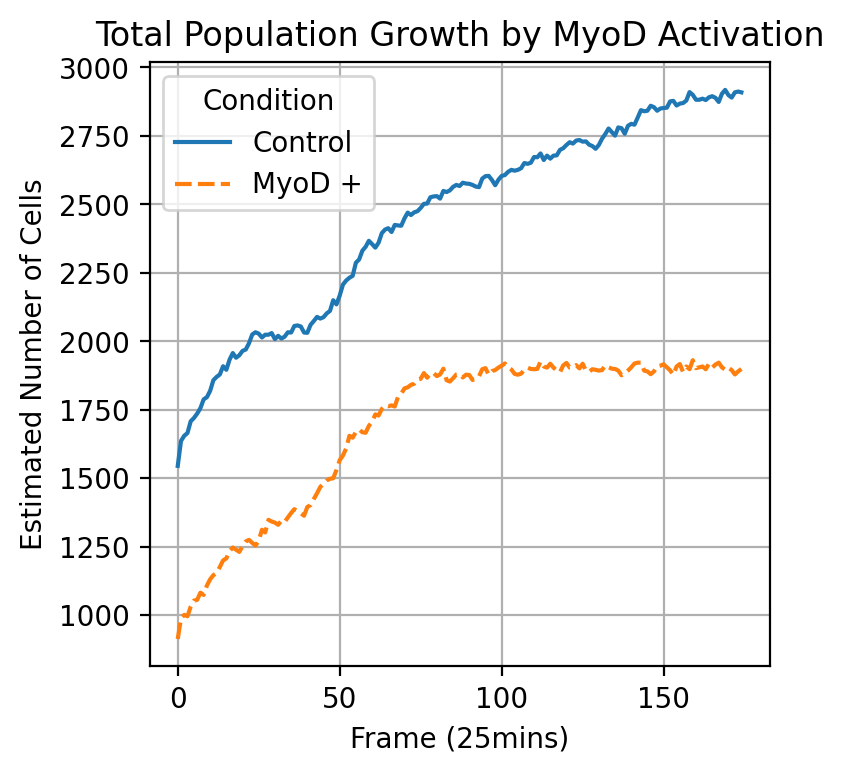

In [639]:
counts = df.groupby(['FRAME', 'Condition'], as_index=False)['TRACK_ID'].nunique()
counts = counts[counts['FRAME'] < counts['FRAME'].max()-1 ]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['axes.grid'] = True

sns.lineplot(data=counts,
             x='FRAME', 
             y='TRACK_ID',
             hue='Condition',
             err_style="bars", 
             style='Condition',
             ci=68)

plt.ylabel("Estimated Number of Cells")
plt.xlabel("Frame (25mins)")
plt.title(f"Total Population Growth by MyoD Activation")

In [640]:
mask = (df['has_green'] == 1) 
df = df[mask].reset_index(drop=True)

print(df.shape)
print(df['TRACK_ID'].nunique())

(554889, 78)
12230


In [641]:
mask = (df['green_max'] > 100) 
df = df[mask].reset_index(drop=True)

In [642]:
# get per-frame means
grped = df.groupby('FRAME', as_index=False).agg(
        frame_green_mean = ('MEAN_INTENSITY01', np.mean),
        frame_red_mean = ('MEAN_INTENSITY03', np.mean)
)

df = pd.merge(df, 
              grped, 
              how='left',
              on=['FRAME'])

df['normed_green'] = df['MEAN_INTENSITY01'] - df['frame_green_mean']
df['normed_red'] = df['MEAN_INTENSITY03'] - df['frame_red_mean']

df[['TRACK_ID', 'FRAME',
   'normed_green', 
   'normed_red']].head()

,TRACK_ID,FRAME,normed_green,normed_red
0,3,0,-62.905383,73.927726
1,3,1,-68.870343,96.628983
2,3,2,-71.912202,72.719541
3,3,3,-71.349674,73.950422
4,3,4,-71.713522,72.570960


<AxesSubplot:xlabel='normed_green', ylabel='Count'>

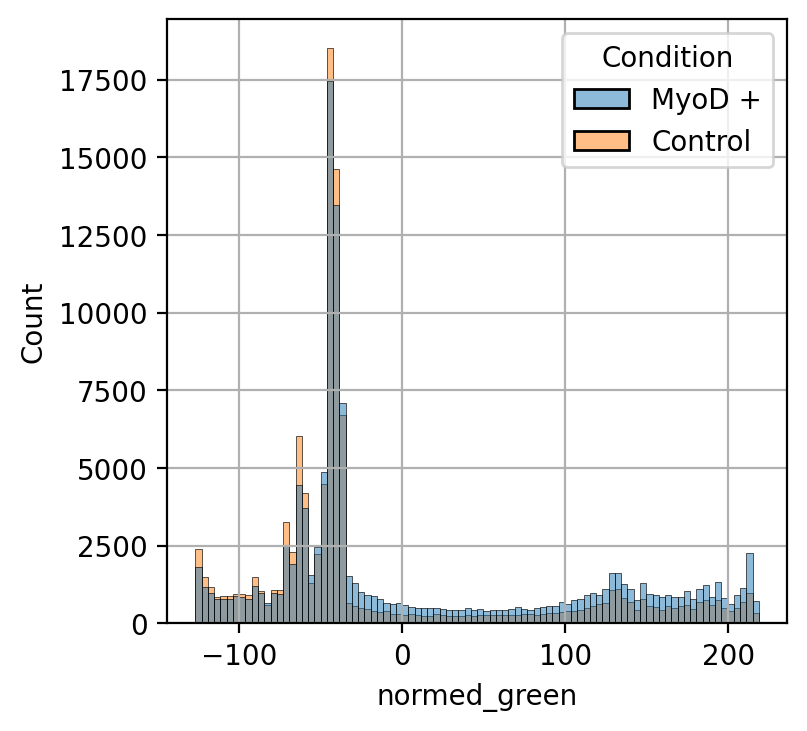

In [643]:
sns.histplot(data=df,
            x='normed_green',
            hue='Condition')

<AxesSubplot:xlabel='normed_red', ylabel='Count'>

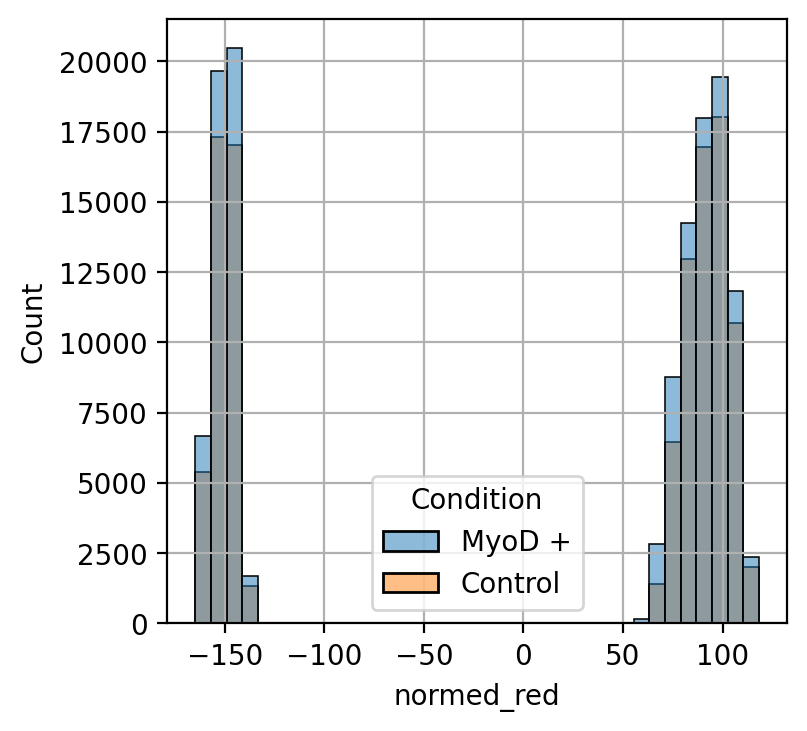

In [644]:
sns.histplot(data=df,
            x='normed_red',
            hue='Condition')

In [645]:
tmp = df.copy()

tmp['max_step'] = tmp.groupby('TRACK_ID')['STEP'].transform(np.max)
tmp = tmp[tmp['max_step'] > 54] # long tracks continuously detected

tmp = tmp[tmp['FRAME'] < 110] # tracks in first 38 hours

# smooth the signals
tmp['rolling_green'] = tmp.groupby('TRACK_ID')['normed_green'].transform(lambda s: s.rolling(3, min_periods=1).mean())
tmp['rolling_red'] = tmp.groupby('TRACK_ID')['normed_red'].transform(lambda s: s.rolling(3, min_periods=1).mean())

# drop nans
tmp = tmp[tmp.notna()]

# binarize
tmp['PF_green'] = np.where(tmp['rolling_green'] > -100.0, 1, 0)
tmp['PF_red'] = np.where(tmp['rolling_red'] > 0.0, 1, 0)

print(tmp['PF_green'].sum() / len(tmp))
print(tmp['PF_red'].sum() / len(tmp))

# assign states
def get_state(row):
    
    if row['rolling_green'] > -75 and row['rolling_red'] > 0:
        return "G2/M"
    elif row['rolling_red'] > 0 and row['rolling_green'] < -75:
        return "S"
    else:
        return "G1"
    
tmp['state'] = tmp[['rolling_green', 'rolling_red']].apply(lambda x: get_state(x), axis=1)
print(tmp['state'].value_counts())
print()
tmp['state'].value_counts(normalize=True)


0.8949510826305555
0.6166812763856563
G2/M    50034
G1      38044
S       11171
Name: state, dtype: int64



G2/M    0.504126
G1      0.383319
S       0.112555
Name: state, dtype: float64

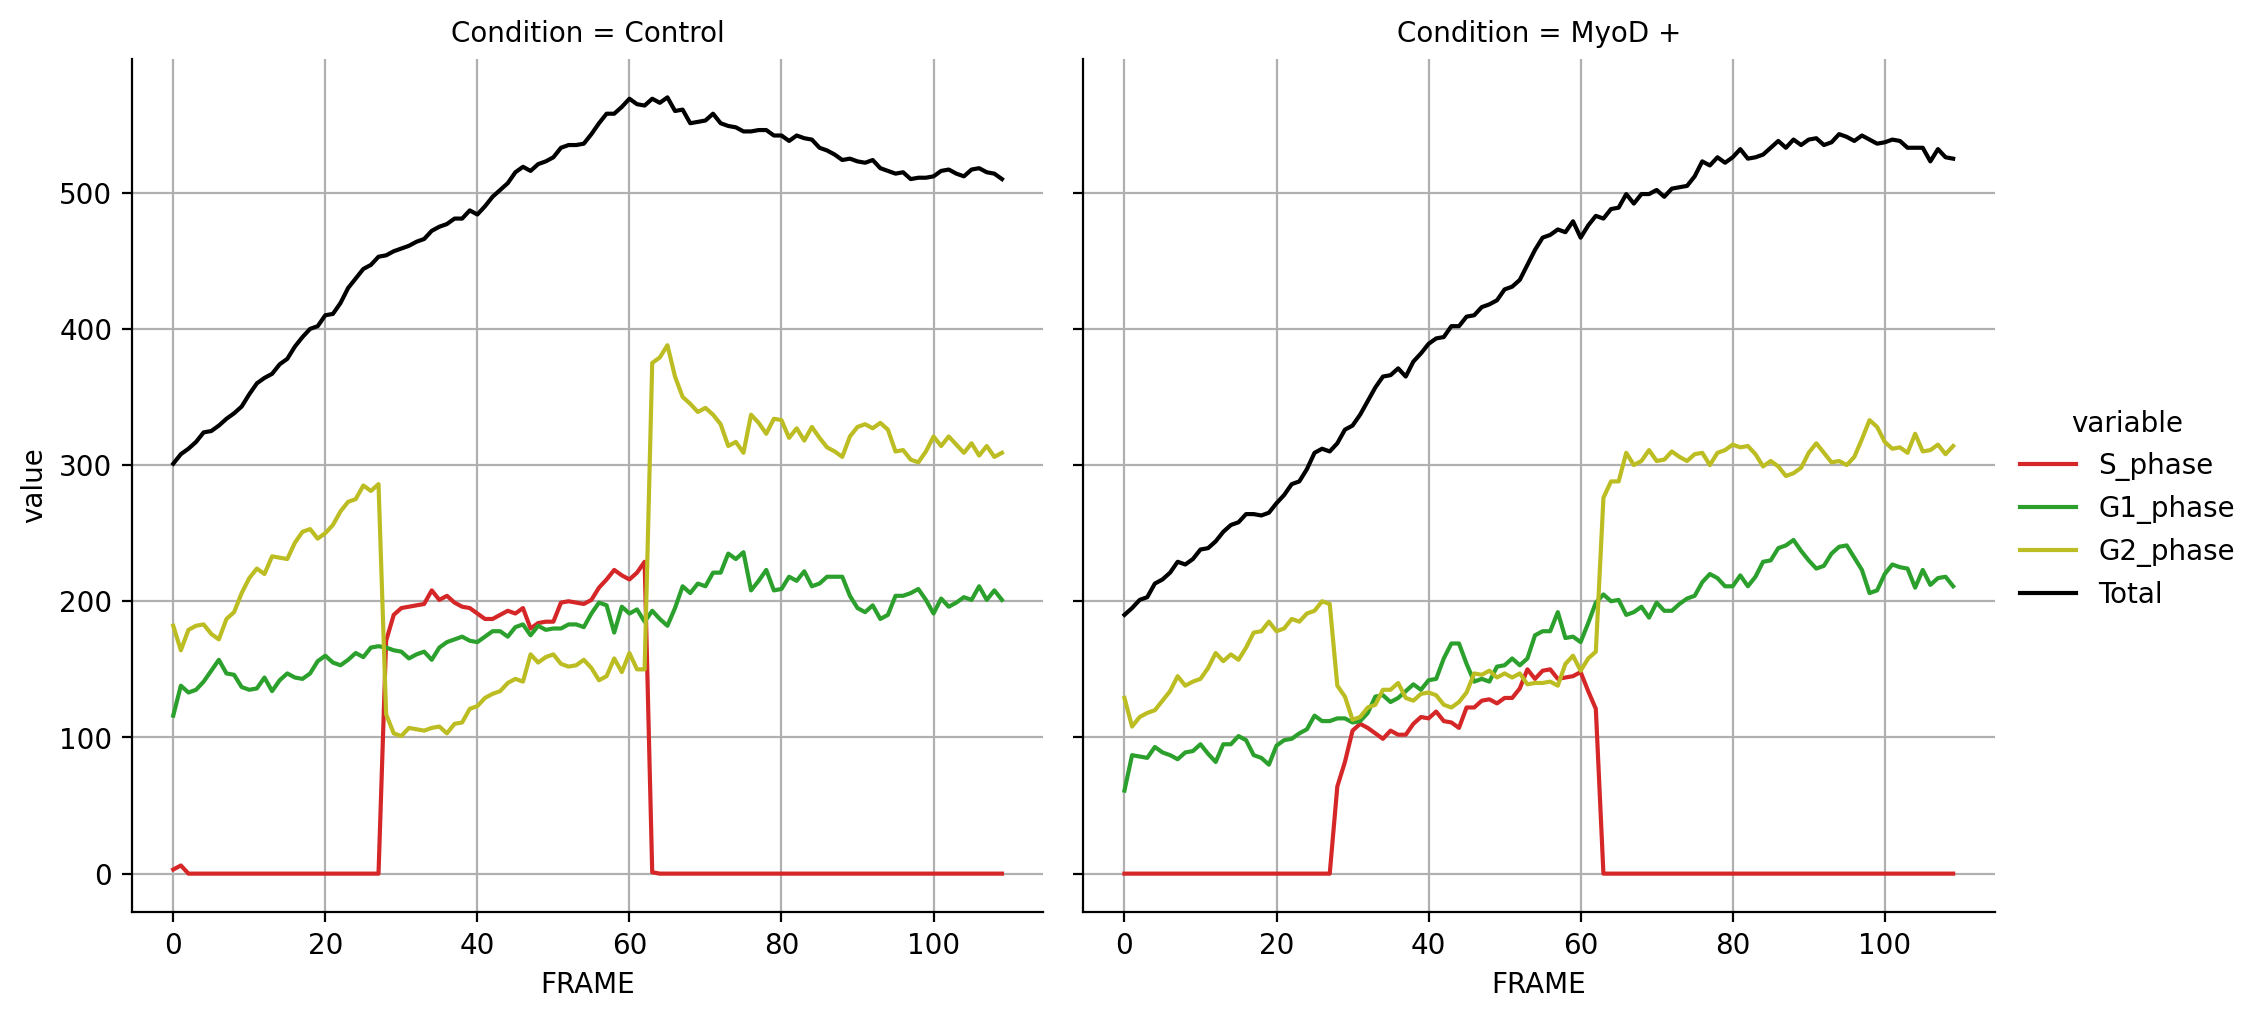

In [646]:
def count_s(grp):
    return len([x for x in grp if x == 'S'])

def count_g1(grp):
    return len([x for x in grp if x == 'G1'])

def count_g2(grp):
    return len([x for x in grp if x == 'G2/M'])


test = tmp.groupby(['FRAME', 'Condition'], as_index=False).agg(
    S_phase = ('state', count_s),
    G1_phase = ('state', count_g1),
    G2_phase = ('state', count_g2),
)

test['Total'] = test['S_phase'] + test['G1_phase'] + test['G2_phase']


test = pd.melt(test, id_vars=['FRAME', 'Condition'], value_vars=['S_phase', 'G1_phase', 'G2_phase', 'Total'])


sns.relplot(data=test,
            x='FRAME',
            y='value',
            hue='variable',
            kind='line',
            col='Condition',
            palette=['C3', 'C2', 'C8', 'k'])

In [635]:
t = pd.read_csv('/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/analysis_files/C7/trackmate/Spots in tracks statistics.csv')
t.head()

,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,MANUAL_COLOR,MEAN_INTENSITY,MEDIAN_INTENSITY,MIN_INTENSITY,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR
0,ID9910231,9910231,0,15.596,2169.145,26.931,0,0.000,0,9,...,-10921639,170.000,255,0,255,21930,120.677,12.794,1.0,1.409
1,ID9965898,9965898,0,14.748,2165.146,16.043,0,1337.247,1,9,...,-10921639,140.349,255,0,255,18105,127.345,12.588,1.0,1.102
2,ID9910230,9910230,1,13.390,43.895,23.506,0,0.000,0,9,...,-10921639,126.512,0,0,255,16320,127.993,8.615,1.0,0.988
3,ID9965900,9965900,1,13.004,44.293,20.788,0,1337.247,1,9,...,-10921639,116.628,0,0,255,15045,127.531,8.674,1.0,0.915
4,ID9979741,9979741,1,13.853,44.652,19.563,0,2674.494,2,9,...,-10921639,134.419,255,0,255,17340,127.808,8.777,1.0,1.052


In [130]:
data_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/analysis_files/"
b3_path = f"{data_dir}B3/segmentation/"
c7_path = f"{data_dir}C7/segmentation/"

dfs = []

for f in os.listdir(b3_path):
    _path = f"{b3_path}{f}"
    t = pd.read_csv(_path)
    t['Condition'] = 'MyoD +'
    dfs.append(t)
    
for f in os.listdir(c7_path):
    _path = f"{c7_path}{f}"
    t = pd.read_csv(_path)
    t['Condition'] = 'Control'
    dfs.append(t)

seg = pd.concat(dfs, ignore_index=True)
seg.head()

get_channel = lambda x: int(x[2])
get_time = lambda x: int(str(x).split("t:")[1].split("/")[0])
get_experiment =  lambda x: str(x).split("#")[1]
get_file =  lambda x: str(x).split(" - ")[1].split("#")[0].strip()

seg['channel'] =seg['Slice'].apply(get_channel)
seg['frame'] = seg['Slice'].apply(get_time)
seg['experiment'] = seg['Slice'].apply(get_experiment)
seg['file'] = seg['Slice'].apply(get_file)

seg.head()

,Slice,Count,Total Area,Average Size,%Area,Mean,Condition,channel,frame,experiment,file
0,c:3/4 t:1/177 - 2015-05-13-20-Scene2-B3.czi #1,286,72287.130,252.752,0.483,255,MyoD +,3,1,1,2015-05-13-20-Scene2-B3.czi
1,c:3/4 t:2/177 - 2015-05-13-20-Scene2-B3.czi #1,292,71053.489,243.334,0.474,255,MyoD +,3,2,1,2015-05-13-20-Scene2-B3.czi
2,c:3/4 t:3/177 - 2015-05-13-20-Scene2-B3.czi #1,298,72504.266,243.303,0.484,255,MyoD +,3,3,1,2015-05-13-20-Scene2-B3.czi
3,c:3/4 t:4/177 - 2015-05-13-20-Scene2-B3.czi #1,307,75319.350,245.340,0.503,255,MyoD +,3,4,1,2015-05-13-20-Scene2-B3.czi
4,c:3/4 t:5/177 - 2015-05-13-20-Scene2-B3.czi #1,312,79241.252,253.978,0.529,255,MyoD +,3,5,1,2015-05-13-20-Scene2-B3.czi


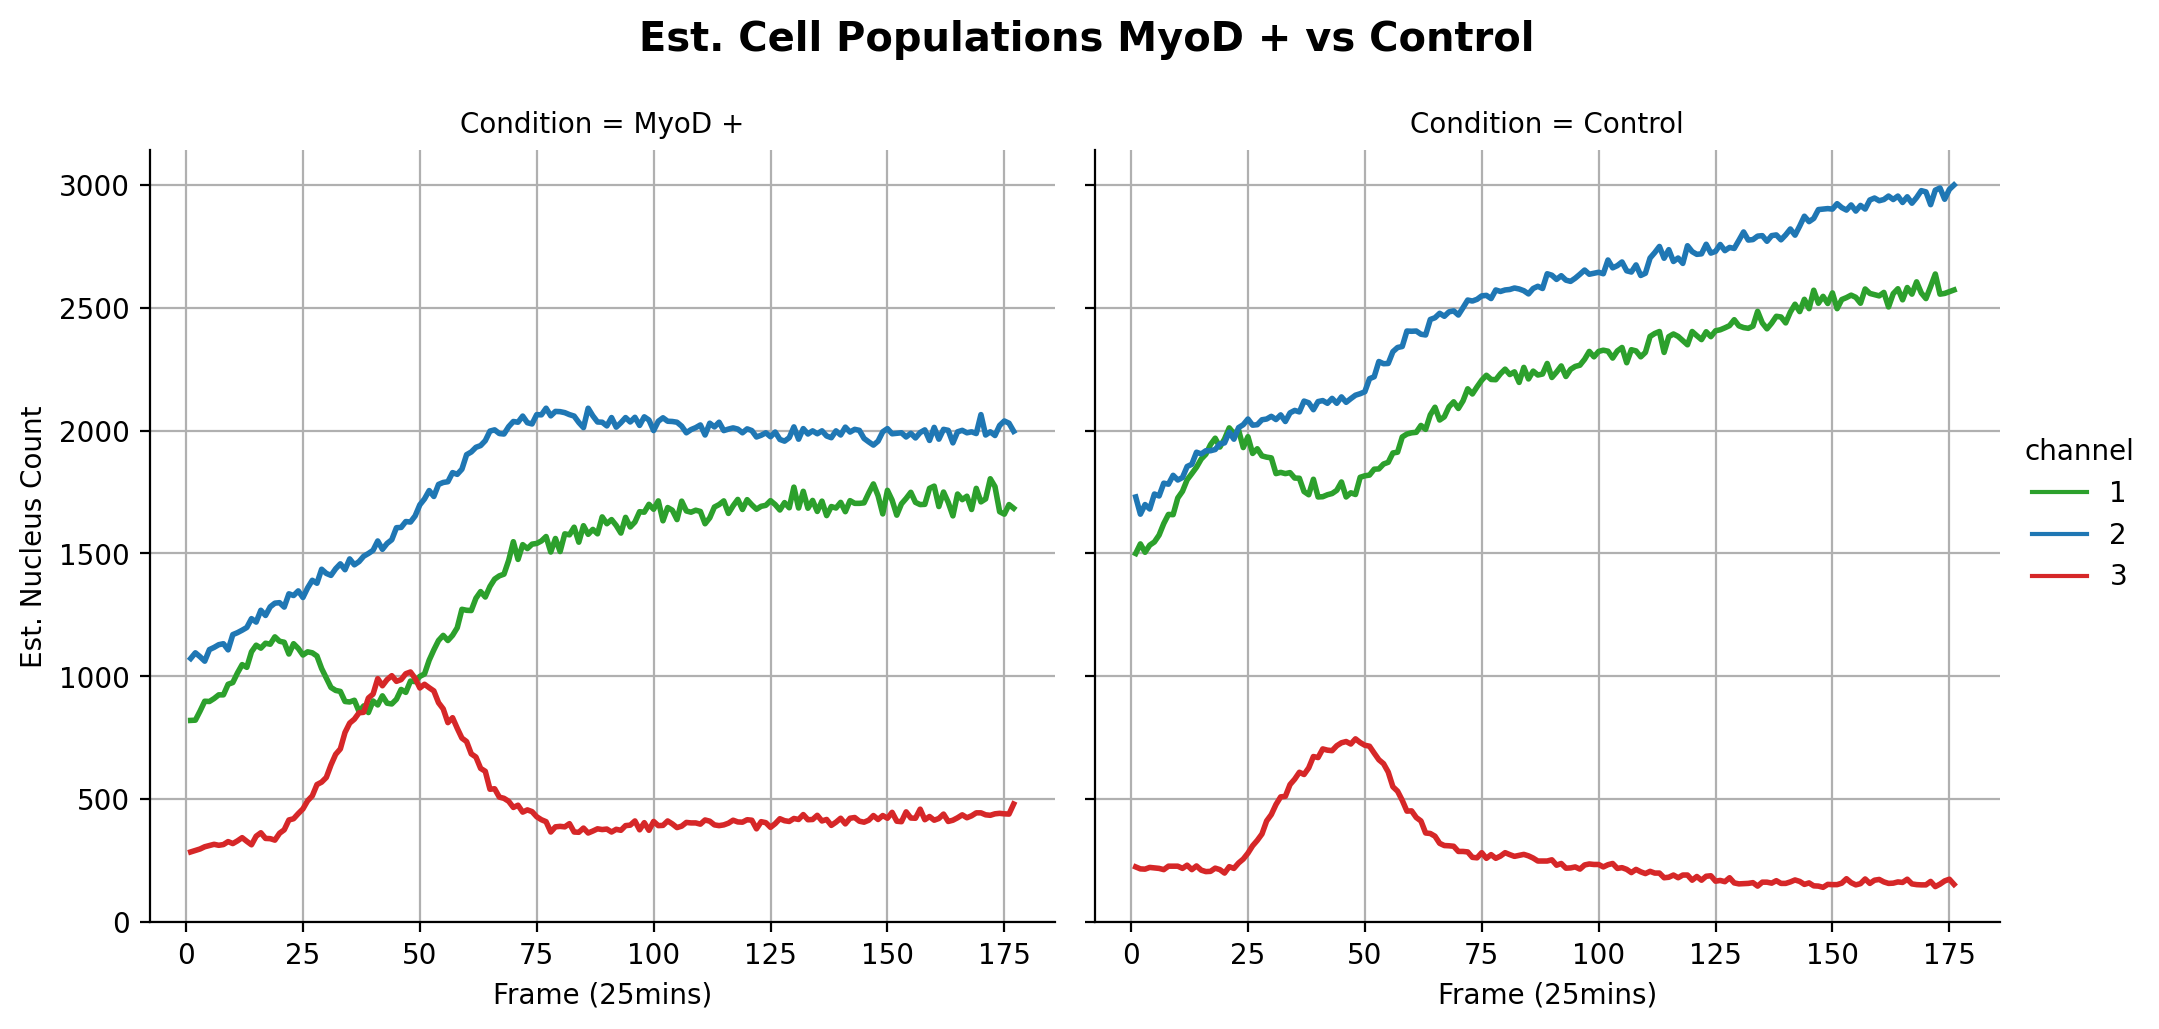

In [131]:
# get simple cell counts over time


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['axes.grid'] = True

p = sns.relplot(data=seg,
             x='frame', 
             y='Count',
             kind="line",
             hue = 'channel',
             palette=['C2', 'C0', 'C3'],
             col='Condition',
             lw=2)

p.fig.suptitle("Est. Cell Populations MyoD + vs Control" ,
               fontsize = 'x-large' , 
               fontweight = 'bold' )

# Adjust subplots so that titles don't overlap
p.fig.subplots_adjust( top = 0.85 )

p.set_axis_labels( "Frame (25mins)" , "Est. Nucleus Count" )